## 共通処理

In [1]:
# 必要なパッケージをインポート
# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

import random

In [2]:
import pymc as pm
import arviz as az

## ch5

### 潜在変数モデル: クラスタリング(3クラス潜在変数モデル)

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


<Axes: xlabel='petal_width', ylabel='Count'>

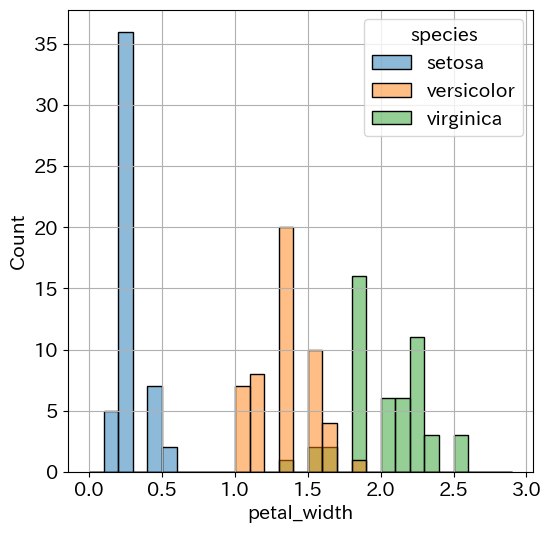

In [18]:
# データ確認
df = sns.load_dataset("iris")

print(df.shape)
display(df.head())
df["species"].value_counts()


sns.histplot(data = df, x = "petal_width", 
             bins=np.arange(0, 3, 0.1),
             hue="species")

In [23]:
# データ準備とパラメータ設定
X = df["petal_width"].values # 観測データ
size = X.shape # データ件数
n_components = 3 # 分類先クラス数

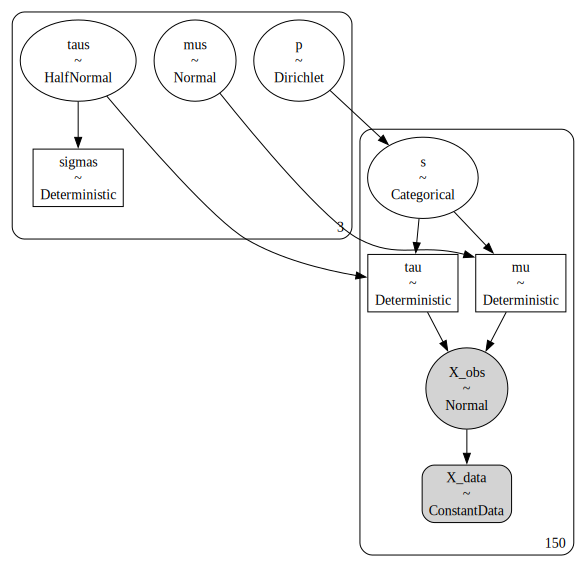

In [25]:
model = pm.Model()
with model:
    # 観測値をConstantDataで定義
    X_data = pm.ConstantData("X_data", X)

    # 各クラスに属する確率を示すn要素のベクトル
    p = pm.Dirichlet("p", a=np.ones(n_components))

    # pの確率値を基にどのクラスに属するかを返す(潜在変数)
    s = pm.Categorical("s", p=p, shape = size)

    # 各クラスの平均値
    mus = pm.Normal("mus", mu=0.0, sigma=10.0, shape=n_components)
    # 各クラスのバラツキ。tauで定義する。(tau = 1 / sigma^2)
    taus = pm.HalfNormal("taus", sigma=10.0, shape=n_components)

    # 分散は後ほど確認したいので、別途求めておく
    sigmas = pm.Deterministic("sigmas", 1/pm.math.sqrt(taus))

    # 各クラスごとに潜在変数からmuとtauを求める
    mu = pm.Deterministic("mu", mus[s])
    tau = pm.Deterministic("tau", taus[s])

    # 確率変数X_obsの定義
    # 各インデックス(クラス)ごとに、sによって割り当てられた個数分のパラメータmu, tauの組み合わせが入っている
    X_obs = pm.Normal("X_obs", mu = mu, tau=tau, observed = X_data)

# モデルの可視化
g = pm.model_to_graphviz(model)
display(g)

In [26]:
# サンプリング
with model:
    idata = pm.sample(random_seed=42, 
                      chains = 1, 
                      # tune = 1000,
                      draws = 2000,
                      target_accept = 0.99
                      )

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>CategoricalGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 261 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


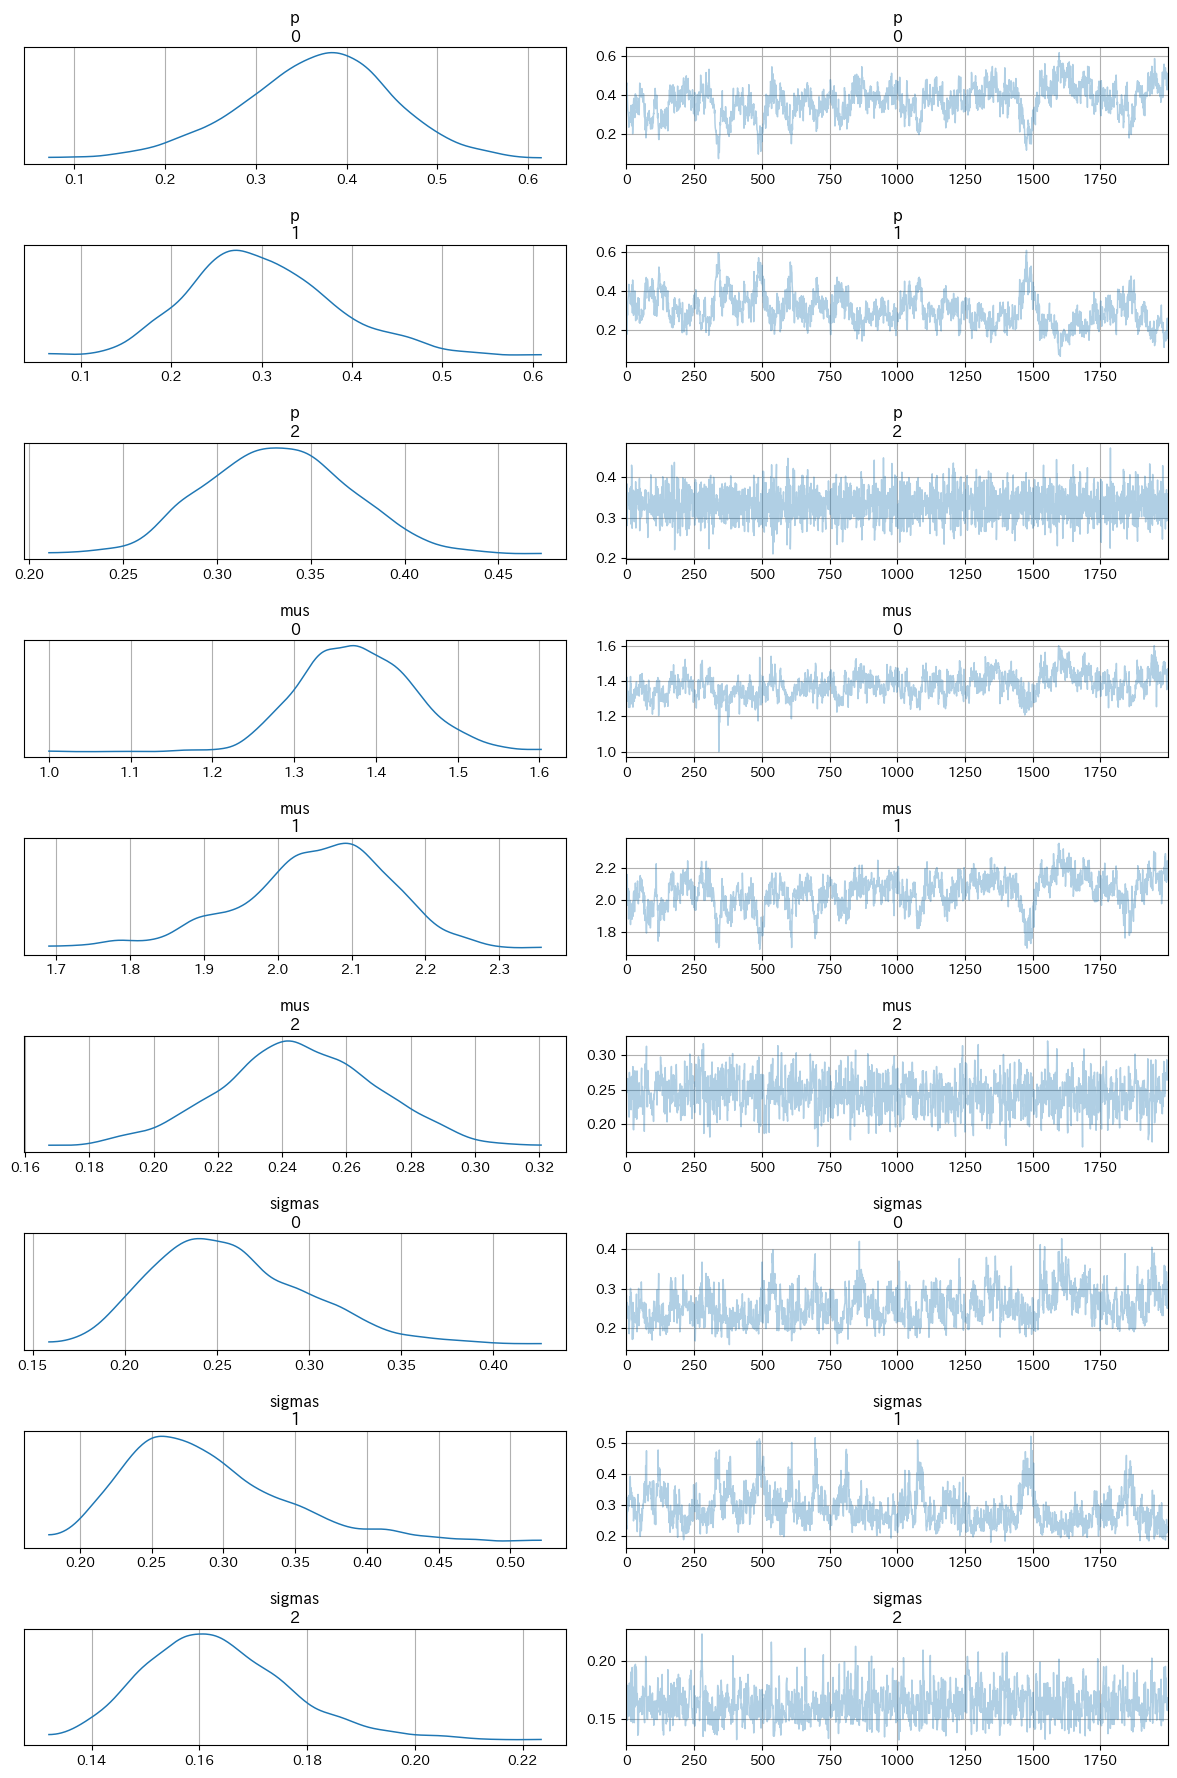

In [27]:
az.plot_trace(idata, var_names=["p", "mus", "sigmas"], compact=False)
plt.tight_layout();

# 正しくベイズ推論できてるいるかの判断
# 1. pの分布が0または1に偏っているものがない
# 2. musの分布: musの値が狭い範囲にとどまっている
# 3. sigmaの値が1以下の小さな値にとどまっている

In [28]:
summary = az.summary(idata, var_names=["p", "mus", "sigmas"])
display(summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.366,0.082,0.208,0.518,0.015,0.012,26.000,71.000,NaN
p[1],0.301,0.082,0.169,0.471,0.015,0.011,27.000,61.000,NaN
p[2],0.333,0.038,0.264,0.401,0.001,0.000,3805.000,1551.000,NaN
mus[0],1.377,0.068,1.252,1.502,0.016,0.012,20.000,107.000,NaN
mus[1],2.050,0.105,1.859,2.254,0.019,0.014,24.000,68.000,NaN
mus[2],0.245,0.024,0.202,0.294,0.001,0.001,920.000,1112.000,NaN
sigmas[0],0.258,0.042,0.186,0.335,0.006,0.004,52.000,253.000,NaN
sigmas[1],0.288,0.057,0.196,0.400,0.007,0.005,47.000,219.000,NaN
sigmas[2],0.163,0.014,0.139,0.188,0.000,0.000,836.000,819.000,NaN


In [33]:
# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2) / (np.sqrt(2 * np.pi) * sigma)

# 各パラメータの平均値取得
means = summary["mean"]

# muの平均値取得
mean_mu0 = means["mus[0]"]
mean_mu1 = means["mus[1]"]
mean_mu2 = means["mus[2]"]

# sigmaの平均値取得
mean_sigma0 = means["sigmas[0]"]
mean_sigma1 = means["sigmas[1]"]
mean_sigma2 = means["sigmas[2]"]

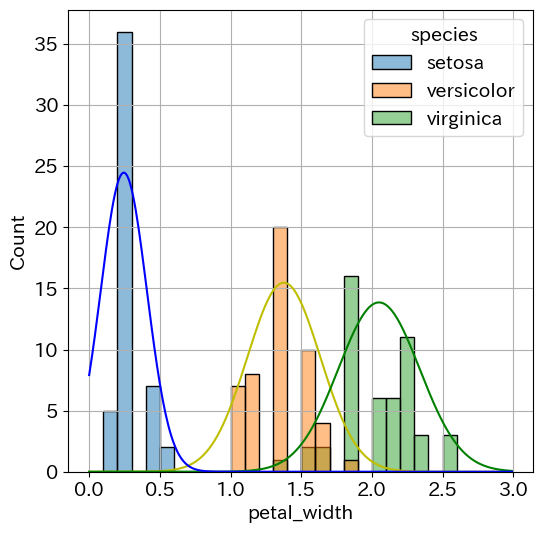

In [36]:
sns.histplot(data = df, x = "petal_width", 
             bins=np.arange(0, 3, 0.1),
             hue="species")

x = np.arange(0, 3, 0.01)
plt.plot(x, norm(x, mean_mu0, mean_sigma0)*10, c="y")
plt.plot(x, norm(x, mean_mu1, mean_sigma1)*10, c="g")
plt.plot(x, norm(x, mean_mu2, mean_sigma2)*10, c="b")

### 潜在変数モデル: クラスタリング(ディレクトリ分布とカテゴリ分布で2クラス潜在変数モデル)

(100, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


<Axes: xlabel='petal_width', ylabel='Count'>

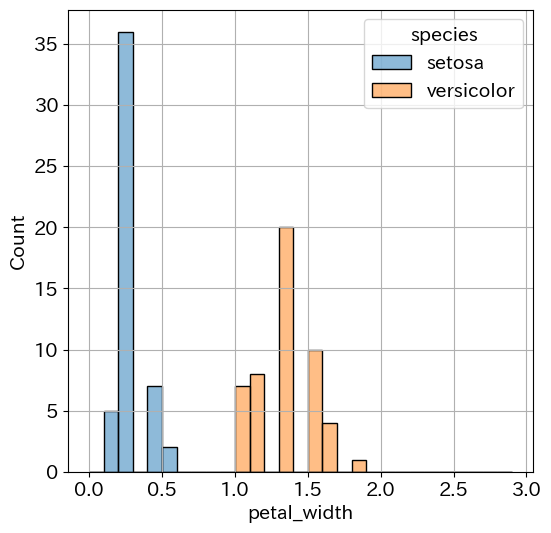

In [38]:
# データ確認
df = sns.load_dataset("iris").head(100)

print(df.shape)
display(df.head())
df["species"].value_counts()


sns.histplot(data = df, x = "petal_width", 
             bins=np.arange(0, 3, 0.1),
             hue="species")

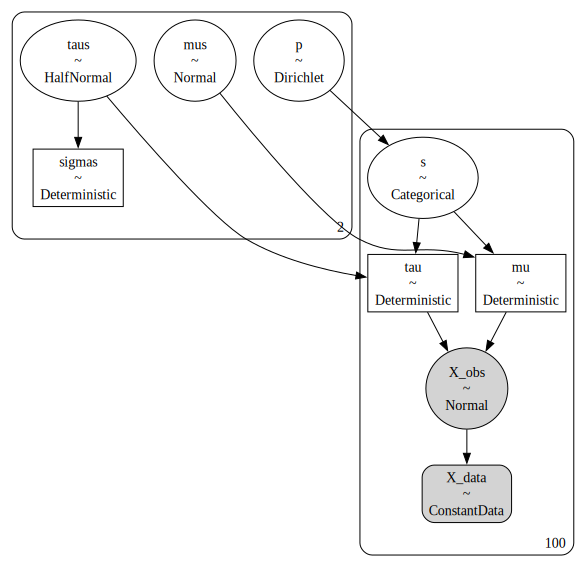

In [39]:
# データ準備とパラメータ設定
X = df["petal_width"].values # 観測データ
size = X.shape # データ件数
n_components = 2 # 分類先クラス数

model = pm.Model()
with model:
    # 観測値をConstantDataで定義
    X_data = pm.ConstantData("X_data", X)

    # 各クラスに属する確率を示すn要素のベクトル
    p = pm.Dirichlet("p", a=np.ones(n_components))

    # pの確率値を基にどのクラスに属するかを返す(潜在変数)
    s = pm.Categorical("s", p=p, shape = size)

    # 各クラスの平均値
    mus = pm.Normal("mus", mu=0.0, sigma=10.0, shape=n_components)
    # 各クラスのバラツキ。tauで定義する。(tau = 1 / sigma^2)
    taus = pm.HalfNormal("taus", sigma=10.0, shape=n_components)

    # 分散は後ほど確認したいので、別途求めておく
    sigmas = pm.Deterministic("sigmas", 1/pm.math.sqrt(taus))

    # 各クラスごとに潜在変数からmuとtauを求める
    mu = pm.Deterministic("mu", mus[s])
    tau = pm.Deterministic("tau", taus[s])

    # 確率変数X_obsの定義
    # 各インデックス(クラス)ごとに、sによって割り当てられた個数分のパラメータmu, tauの組み合わせが入っている
    X_obs = pm.Normal("X_obs", mu = mu, tau=tau, observed = X_data)

# モデルの可視化
g = pm.model_to_graphviz(model)
display(g)

In [40]:
# サンプリング
with model:
    idata = pm.sample(random_seed=42, 
                      chains = 1, 
                      # tune = 1000,
                      draws = 2000,
                      target_accept = 0.99
                      )

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 138 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


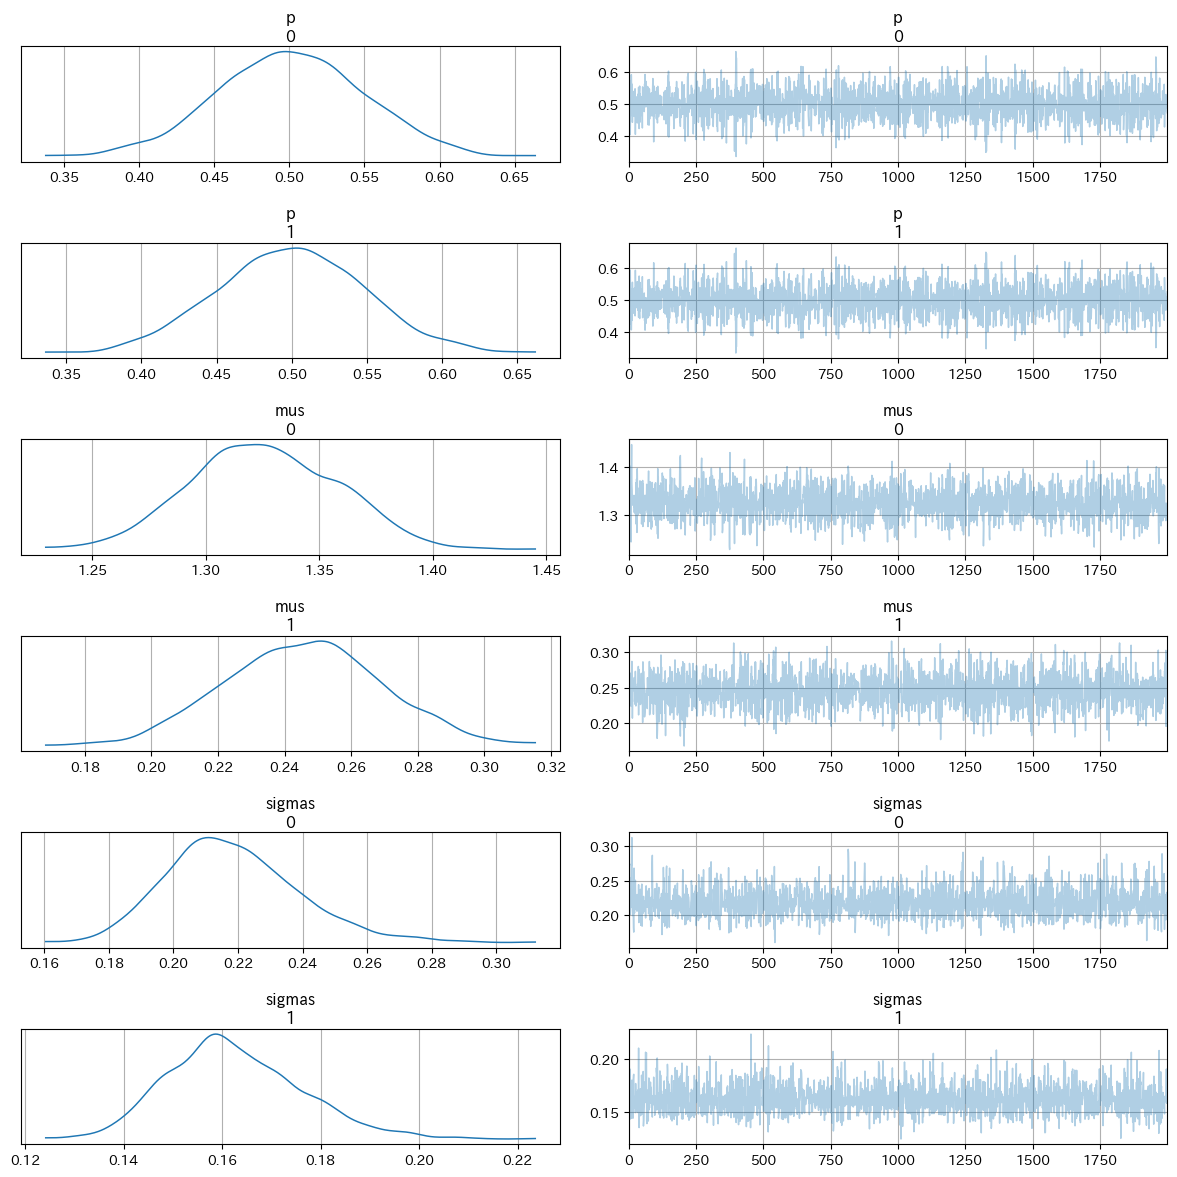

In [41]:
az.plot_trace(idata, var_names=["p", "mus", "sigmas"], compact=False)
plt.tight_layout();

# 正しくベイズ推論できてるいるかの判断
# 1. pの分布が0または1に偏っているものがない
# 2. musの分布: musの値が狭い範囲にとどまっている
# 3. sigmaの値が1以下の小さな値にとどまっている

In [42]:
summary = az.summary(idata, var_names=["p", "mus", "sigmas"])
display(summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.501,0.048,0.413,0.596,0.001,0.001,2619.000,1308.000,NaN
p[1],0.499,0.048,0.404,0.587,0.001,0.001,2619.000,1308.000,NaN
mus[0],1.326,0.032,1.271,1.388,0.001,0.000,2279.000,1129.000,NaN
mus[1],0.246,0.023,0.202,0.288,0.001,0.000,2136.000,1049.000,NaN
sigmas[0],0.218,0.020,0.182,0.256,0.000,0.000,2187.000,1309.000,NaN
sigmas[1],0.163,0.014,0.139,0.189,0.000,0.000,2114.000,1371.000,NaN


In [43]:
# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2) / (np.sqrt(2 * np.pi) * sigma)

# 各パラメータの平均値取得
means = summary["mean"]

# muの平均値取得
mean_mu0 = means["mus[0]"]
mean_mu1 = means["mus[1]"]

# sigmaの平均値取得
mean_sigma0 = means["sigmas[0]"]
mean_sigma1 = means["sigmas[1]"]

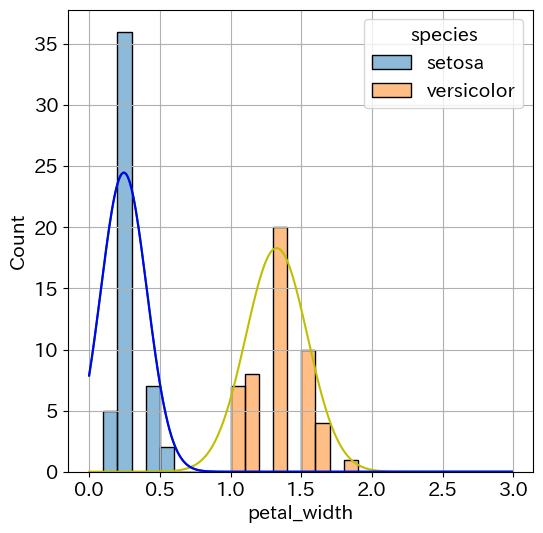

In [44]:
sns.histplot(data = df, x = "petal_width", 
             bins=np.arange(0, 3, 0.1),
             hue="species")

x = np.arange(0, 3, 0.01)
plt.plot(x, norm(x, mean_mu0, mean_sigma0)*10, c="y")
plt.plot(x, norm(x, mean_mu1, mean_sigma1)*10, c="g")
plt.plot(x, norm(x, mean_mu2, mean_sigma2)*10, c="b")